# Unexpected behaviour with ranges in RooFit

Ranges in RooFit don't do what I thought they do. You cannot use them to fit around a blinded area. They will cause the fit to converge to the wrong point. 
I wouldn't go as far as calling this a bug, but it is hard to imagine a situation where this is actually desired behavior.

In [1]:
%matplotlib inline
import ROOT
import scipy.integrate
import numpy
import matplotlib.pyplot as plt

## First Step: Make a fit without ranges

#### Define an exponential PDF

This could be any other pdf.

In [2]:
mass = ROOT.RooRealVar("mass","mass", 0, 100)
exponent = ROOT.RooRealVar("exponent","exponent", -0.04, -0.5, 0.)
model = ROOT.RooExponential("data_model", "data_model", mass, exponent)

#### Generate some data

In [3]:
ROOT.RooRandom.randomGenerator().SetSeed(2) # setting the seed so we're all on the same page
data = model.generate(ROOT.RooArgSet(mass),100)

#### For comparison, fit once on the full range
(and plot it too)

In [4]:
model.fitTo(data)
exponent_full_range_fit = exponent.getVal()
print "exponent after fit:", exponent.getVal()

plot = mass.frame()
data.plotOn(plot)
model.plotOn(plot,ROOT.RooFit.LineColor(4))


exponent after fit: -0.0386446607376


<ROOT.RooPlot object ("frame_mass_4493e70") at 0x4493e70>

#### And now fit on two ranges
 (and plot it)

In [5]:
mass.setRange("left",  3, 10)
mass.setRange("right", 60, 100)

model.fitTo(data, ROOT.RooFit.Range("left,right"))
exponent_limited_range_fit = exponent.getVal()
print "exponent after range limited fit:", exponent_limited_range_fit
model.plotOn(plot,ROOT.RooFit.LineColor(2))
plot.Draw()

exponent after range limited fit: -0.128974013036


## Where is the problem?

The fit result for the red curve appears to be incorrect. It appears that even if one only considers the data *in the defined ranges*, the blue line is still a *better* fit than the "best" fit returned by RooFit.

Something seems to be going wrong.

** Disclaimer: Depending on the random events that were generated by your system, it might be that you don't actually see a problem in your fit. This of course can happen. However, the following plots should still allow me to make my point, so please stick around **


## Proof that RooFit makes a mistake:

To put some numbers to this, let's look at the Likelihood of the events *in the ranges* as a function of the exponent.


   

In [6]:
def get_norm(exponent, ranges):
    norm = 0
    for range in ranges:
        integral, error = scipy.integrate.quad(lambda x: numpy.exp(exponent * x), range[0], range[1])
        norm += integral
    return norm

def get_llh(exponent, points):
    norm = get_norm(exponent,ranges = [(3, 10), (60, 100)])
    llh = 1.
    for point in points:
        llh *= numpy.exp(exponent * point)/norm
    return llh

def rooDataSet_to_list(data):
    data_list = []
    for i in range(0, data.numEntries()):
        event = data.get(i)
        data_list.append(event.getRealValue("mass"))
    return data_list
        


In [7]:
events_in_ranges = [x for x in rooDataSet_to_list(data) if (x>3 and x<10) or x>60 ]

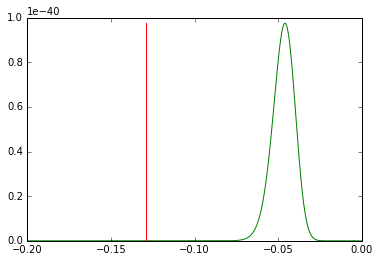

In [8]:
xs = numpy.linspace(-0.2,0,1000)
ys = [get_llh(x, events_in_ranges) for x in xs]
plt.plot(xs,ys, color="green")
plt.plot([exponent_limited_range_fit,exponent_limited_range_fit],[0,max(ys)], color="red")
plt.show()

So it appears that RooFit's best fit value isn't even close to the maximum of the likelihood. How is that possible? After all, isn't the purpose of the maximum likelihood fit to find the value of the exponent that maximises the likeihood?

## The answer 
It was Igor who discovered the answer. RooFit doesn't maximise the likelihood. Instead it performs a simultaneous fit of two exponentials on the two ranges, with a shared parameter. If an event is in the left range, it normalises the PDF to the left range only. Same for the right.

I wouldn't go as far as calling this a bug, but it is hard to imagine a situation where this is actually desired behavior.

## Proof that RooFit uses the wrong norm:

Let's calculate the likelihood using the "incorrect" normalization method:


In [9]:

def get_llh_with_incorrect_norm(exponent, points):
    norm_left  = get_norm(exponent,ranges = [(3, 10)])
    norm_right = get_norm(exponent,ranges = [(60, 100)])
    llh = 1.
    for point in points:
        if point < 15:
            llh *= numpy.exp(exponent * point)/norm_left
        else:
            llh *= numpy.exp(exponent * point)/norm_right
    return llh

false_ys = [get_llh_with_incorrect_norm(x, events_in_ranges) for x in xs]
    

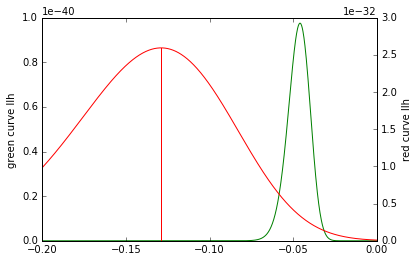

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(xs,ys, color="green")
ax.set_ylabel("green curve llh")
ax2 = ax.twinx()
ax2.plot(xs,false_ys, color="red")
ax2.plot([exponent_limited_range_fit,exponent_limited_range_fit],[0,max(false_ys)], color="red")
ax2.set_ylabel("red curve llh")
plt.show()

The maximum of the incorrectly calculated likelihood matches exactly RooFit's best fit value. That's hardly a coincidence.

## What can be done?

 * When fitting a blinded dataset, it might be possible to use convolution with a step function.
 * We have to change the interface for ranges in RooFit and start supporting Normalization on multiple ranges.